In [1]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

# Neural Data

## Load Data

In [2]:
%%time
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

CPU times: user 1min 31s, sys: 8.62 s, total: 1min 39s
Wall time: 6min 59s


## Up and Down States

In [98]:
area_spike_dict = {}
for area in session_info['areas']:
    print(area)
    unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC
FEF
CPB
7b


In [100]:
up_down_dict = get_up_down(area_spike_dict)

# Big Run

In [61]:
%%time
results = load("../../__data__/slds/slds_biiiig_run_full_brain")

CPU times: user 1.97 s, sys: 25 s, total: 27 s
Wall time: 2min 27s


In [62]:
start_times = [r['start_time'] for r in results]
start_times.sort()
start_times = np.array(start_times)

n_disc_states = results[0]['slds'].K

duration = results[0]['duration']

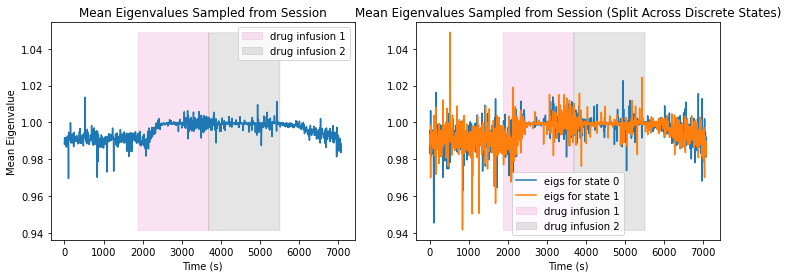

In [63]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

ax = axs[0]
mean_eigs = np.array([results[i]['criticality_inds'].mean() for i in range(len(results))])
ax.plot(start_times, mean_eigs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session")


ax = axs[1]
mean_eigs = np.array([results[i]['criticality_inds'].mean(axis=1) for i in range(len(results))])
for i in range(n_disc_states):
    ax.plot(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
ax.set_xlabel('Time (s)')
# ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()
ax.yaxis.set_tick_params(labelbottom=True)

# make coloured portions the same size
ax = axs[0]
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()

plt.show()

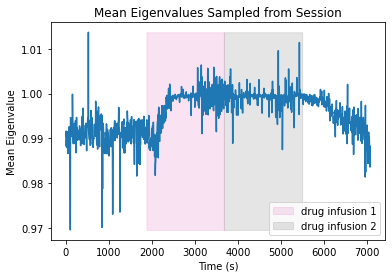

In [64]:
fig = plt.figure()
ax = plt.gca()
mean_eigs = np.array([results[i]['criticality_inds'].mean() for i in range(len(results))])
ax.plot(start_times, mean_eigs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session")
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()
plt.show()

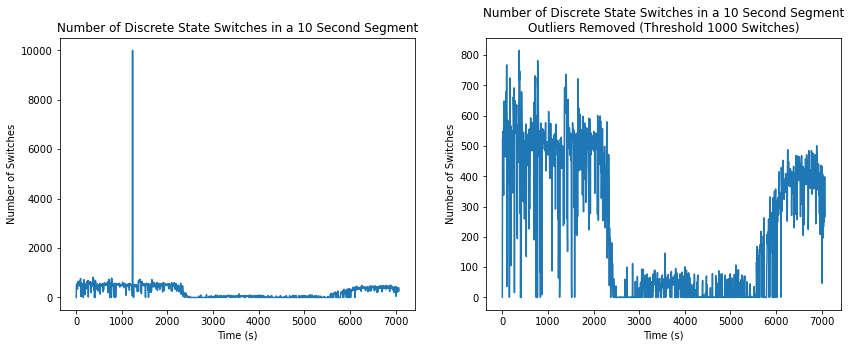

In [65]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
num_switches = np.array([np.sum(np.diff(results[i]['disc_states']) != 0) for i in range(len(results))])
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.subplot(1, 2, 2)
thresh = 1000
num_switches[num_switches > thresh] = num_switches[num_switches <= thresh].mean()
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment\nOutliers Removed (Threshold {thresh} Switches)")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.show()

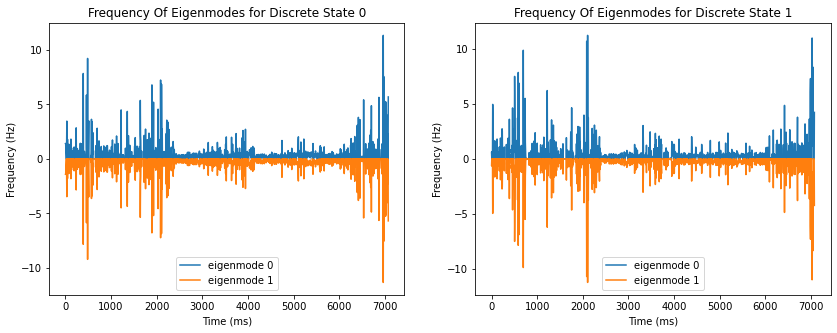

In [66]:
plt.figure(figsize=(14, 5))

def to_freqs(x):
    freqs = np.zeros(x.shape)
    # iterate through discrete states
    for n in range(x.shape[0]):
        # iterate through eigenmodes
        for i in range(x.shape[1]):
            freqs[n, i] = np.angle(x[n, i])/(2*np.pi*dt)
    return freqs
# shape of freqs is (len(results), n_discrete_states, latent_dim)
freqs = np.array([to_freqs(results[i]['eigs']) for i in range(len(results))])

plt.subplot(1, 2, 1)
state = 0
for i in range(results[i]['eigs'].shape[1]):
    plt.plot(start_times, [freqs[j][state, i] for j in range(len(freqs))],  label=f'eigenmode {i}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.title(f'Frequency Of Eigenmodes for Discrete State {state}')

plt.subplot(1, 2, 2)
state = 1
for i in range(results[i]['eigs'].shape[1]):
    plt.plot(start_times, [freqs[j][state, i] for j in range(len(freqs))],  label=f'eigenmode {i}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.title(f'Frequency Of Eigenmodes for Discrete State {state}')

plt.show()

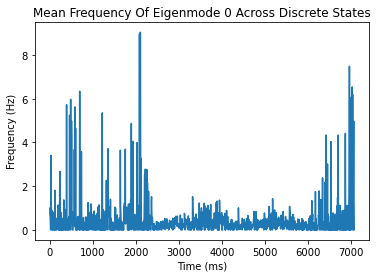

In [75]:
mean_freq_mode_0_across_disc_states = freqs[:, :, 0].mean(axis=1)
plt.plot(start_times, mean_freq_mode_0_across_disc_states)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Mean Frequency Of Eigenmode 0 Across Discrete States')
plt.show()

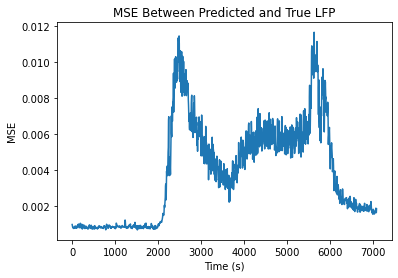

In [74]:
mse = np.array([results[i]['mse'] for i in range(len(results))])
plt.plot(start_times, mse)
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.title("MSE Between Predicted and True LFP")
plt.show()

# Power Spectrum Comparison

In [89]:
spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=1, # (2, 3, 4)
#     freq_width=2,
    spacing=0.5,
    freq_range=[0, 80],
)
k = spectrogram_kwargs['time_width']*fs
r = (spectrogram_kwargs['time_width'] - spectrogram_kwargs['spacing'])*fs
num_timepts = int((lfp.shape[0] - r)/(k - r))
fs = 1/dt

max_power_freqs = np.zeros((lfp.shape[1], num_timepts))
for neuron_i in tqdm(range(lfp.shape[1])):
    signal_in = lfp[:, neuron_i]
    spec, freq, timepts = spectra.spectrogram(signal_in, fs, **spectrogram_kwargs)
    
    max_power_freqs[neuron_i] = freq[spec.argmax(axis=0)]

  0%|          | 0/253 [00:00<?, ?it/s]

In [114]:
freq

array([ 0.       ,  0.9765625,  1.953125 ,  2.9296875,  3.90625  ,
        4.8828125,  5.859375 ,  6.8359375,  7.8125   ,  8.7890625,
        9.765625 , 10.7421875, 11.71875  , 12.6953125, 13.671875 ,
       14.6484375, 15.625    , 16.6015625, 17.578125 , 18.5546875,
       19.53125  , 20.5078125, 21.484375 , 22.4609375, 23.4375   ,
       24.4140625, 25.390625 , 26.3671875, 27.34375  , 28.3203125,
       29.296875 , 30.2734375, 31.25     , 32.2265625, 33.203125 ,
       34.1796875, 35.15625  , 36.1328125, 37.109375 , 38.0859375,
       39.0625   , 40.0390625, 41.015625 , 41.9921875, 42.96875  ,
       43.9453125, 44.921875 , 45.8984375, 46.875    , 47.8515625,
       48.828125 , 49.8046875, 50.78125  , 51.7578125, 52.734375 ,
       53.7109375, 54.6875   , 55.6640625, 56.640625 , 57.6171875,
       58.59375  , 59.5703125, 60.546875 , 61.5234375, 62.5      ,
       63.4765625, 64.453125 , 65.4296875, 66.40625  , 67.3828125,
       68.359375 , 69.3359375, 70.3125   , 71.2890625, 72.2656

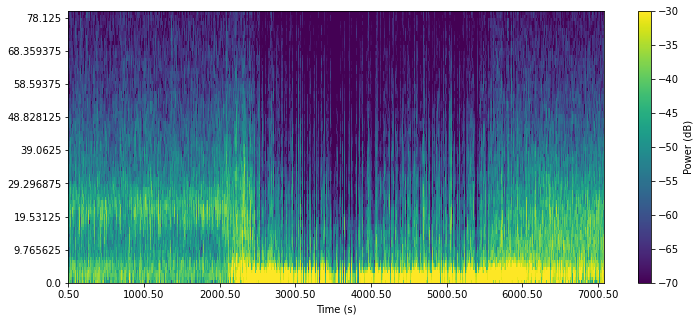

In [91]:
plt.figure(figsize=(12, 5))
plt.pcolormesh(10*np.log10(spec))
xtick_locs = plt.xticks()[0][:-1]
plt.xticks(xtick_locs,[f'{timepts[int(val)]:.2f}' for val in xtick_locs])
plt.xlabel('Time (s)')
ytick_locs = plt.yticks()[0][:-1]
plt.yticks(ytick_locs,[freq[int(val)]for val in ytick_locs])
plt.colorbar(label='Power (dB)')
plt.clim([-70, -30])
plt.show()

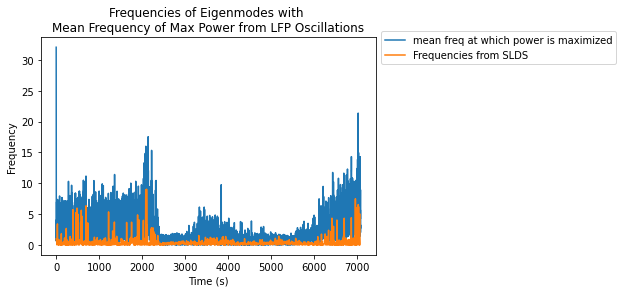

In [96]:
plt.plot(timepts, max_power_freqs.mean(axis=0), label='mean freq at which power is maximized')
max_time = timepts[-1]
indices = start_times <= max_time
plt.plot(start_times[indices], mean_freq_mode_0_across_disc_states[indices], label='Frequencies from SLDS')
plt.plot()
plt.xlabel('Time (s)')
plt.ylabel("Frequency")
plt.title("Frequencies of Eigenmodes with \nMean Frequency of Max Power from LFP Oscillations")
plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
plt.show()

# Up States and Down States

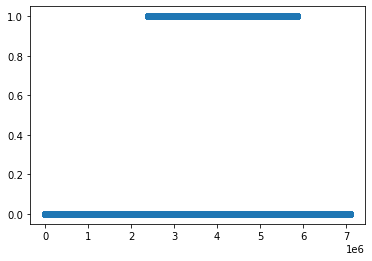

In [107]:

plt.scatter(np.arange(len(up_down_dict['vlPFC'])), up_down_dict['vlPFC'])
plt.show()